---
title: USGS Landsat Cloud Data - Search and Access
---

In [56]:
#import hvplot.xarray
import rasterio as rio
from rasterio.session import AWSSession
import rioxarray
import boto3
import json
import dask
import glob
import re
from pystac_client import Client

In [2]:
# import hvplot

Seach for LS Scenes using STAC API

In [3]:
stac_url = 'https://landsatlook.usgs.gov/stac-server'

In [4]:
ls_cat = Client.open(stac_url)

In [5]:
#ls_cat

In [6]:
[f'{x.title} --- {x.id}' for x in ls_cat.get_children()]

['Landsat Collection 2 Level-2 UTM Surface Reflectance (SR) Product --- landsat-c2l2-sr',
 'Landsat Collection 2 Level-2 UTM Surface Temperature (ST) Product --- landsat-c2l2-st',
 'Landsat Collection 2 Analysis Ready Data (ARD) Level-2 UTM Surface Temperature (ST) Product --- landsat-c2ard-st',
 'Landsat Collection 2 Level-2 Albers Top of Atmosphere Brightness Temperature (BT) Product --- landsat-c2l2alb-bt',
 'Landsat Collection 2 Level-3 Fractional Snow Covered Area (fSCA) Product --- landsat-c2l3-fsca',
 'Landsat Collection 2 Analysis Ready Data (ARD) Level-2 UTM Top of Atmosphere Brightness Temperature (BT) Product --- landsat-c2ard-bt',
 'Landsat Collection 2 Level-1 Product --- landsat-c2l1',
 'Landsat Collection 2 Level-3 Burned Area (BA) Product --- landsat-c2l3-ba',
 'Landsat Collection 2 Level-2 Albers Surface Temperature (ST) Product --- landsat-c2l2alb-st',
 'Landsat Collection 2 Analysis Ready Data (ARD) Level-2 UTM Surface Reflectance (SR) Product --- landsat-c2ard-sr',


In [7]:
list(ls_cat.get_all_collections())

[<CollectionClient id=landsat-c2l2-sr>,
 <CollectionClient id=landsat-c2l2-st>,
 <CollectionClient id=landsat-c2ard-st>,
 <CollectionClient id=landsat-c2l2alb-bt>,
 <CollectionClient id=landsat-c2l3-fsca>,
 <CollectionClient id=landsat-c2ard-bt>,
 <CollectionClient id=landsat-c2l1>,
 <CollectionClient id=landsat-c2l3-ba>,
 <CollectionClient id=landsat-c2l2alb-st>,
 <CollectionClient id=landsat-c2ard-sr>,
 <CollectionClient id=landsat-c2l2alb-sr>,
 <CollectionClient id=landsat-c2l2alb-ta>,
 <CollectionClient id=landsat-c2l3-dswe>,
 <CollectionClient id=landsat-c2ard-ta>]

In [8]:
bbox = [-120,37,-119,38]

In [9]:
datetime_range = '2019-10-01T00:00:00Z/2020-09-30T23:59:59Z'
datetime_range

'2019-10-01T00:00:00Z/2020-09-30T23:59:59Z'

In [10]:
search = ls_cat.search(
    collections = ['landsat-c2l3-fsca'],       # fsca
    bbox = bbox,                          # Specified above
    datetime = datetime_range             # Specified above
)

In [11]:
search.matched()

178

Print first 5 item ids and associated datetime

In [12]:
items = list(search.get_items())
[f'{x.id} --- {x.datetime}' for x in items][:5]

['LC08_CU_003010_20200928_20210504_02_SNOW --- 2020-09-28 18:34:13.371343+00:00',
 'LC08_CU_003009_20200928_20210504_02_SNOW --- 2020-09-28 18:34:01.425823+00:00',
 'LE07_CU_003010_20200927_20210504_02_SNOW --- 2020-09-27 18:05:11.101380+00:00',
 'LE07_CU_003009_20200927_20210504_02_SNOW --- 2020-09-27 18:04:47.213913+00:00',
 'LE07_CU_003010_20200920_20210504_02_SNOW --- 2020-09-20 17:59:27.072009+00:00']

In [13]:
http_links = []

for i in items:
    for a in i.assets.values():
        a_link = json.loads(json.dumps(a.to_dict()))
        if a_link['href'].endswith('.TIF'):
            http_links.append(a_link['href'])
        

In [14]:
len(http_links)

890

In [15]:
http_links[:5]

['https://landsatlook.usgs.gov/level-3/collection02/SNOW/2020/CU/003/010/LC08_CU_003010_20200928_20210504_02_SNOW/LC08_CU_003010_20200928_20210504_02_VIEWABLE_SNOW.TIF',
 'https://landsatlook.usgs.gov/level-3/collection02/SNOW/2020/CU/003/010/LC08_CU_003010_20200928_20210504_02_SNOW/LC08_CU_003010_20200928_20210504_02_GROUND_SNOW.TIF',
 'https://landsatlook.usgs.gov/level-3/collection02/SNOW/2020/CU/003/010/LC08_CU_003010_20200928_20210504_02_SNOW/LC08_CU_003010_20200928_20210504_02_SCAG_SHADE.TIF',
 'https://landsatlook.usgs.gov/level-3/collection02/SNOW/2020/CU/003/010/LC08_CU_003010_20200928_20210504_02_SNOW/LC08_CU_003010_20200928_20210504_02_SCAG_MASK.TIF',
 'https://landsatlook.usgs.gov/level-3/collection02/SNOW/2020/CU/003/010/LC08_CU_003010_20200928_20210504_02_SNOW/LC08_CU_003010_20200928_20210504_02_FSCA_QA.TIF']

In [107]:
s3_links = []

for i in items:
    for a in i.assets.values():
        a_link = json.loads(json.dumps(a.to_dict()))
        if 'alternate' in a_link:
            s3_asset = a_link['alternate']['s3']['href']
            if s3_asset.endswith('.TIF'):
                s3_links.append(s3_asset)

In [108]:
len(s3_links)

890

In [109]:
s3_links[:1]

['s3://usgs-landsat-level-3/collection02/SNOW/2020/CU/003/010/LC08_CU_003010_20200928_20210504_02_SNOW/LC08_CU_003010_20200928_20210504_02_VIEWABLE_SNOW.TIF']

In [111]:
# filter for just ground snow tifs
ground_snow_s3_links = [url for url in s3_links if url.endswith('GROUND_SNOW.TIF')]
print(ground_snow_s3_links[:2])

['s3://usgs-landsat-level-3/collection02/SNOW/2020/CU/003/010/LC08_CU_003010_20200928_20210504_02_SNOW/LC08_CU_003010_20200928_20210504_02_GROUND_SNOW.TIF', 's3://usgs-landsat-level-3/collection02/SNOW/2020/CU/003/009/LC08_CU_003009_20200928_20210504_02_SNOW/LC08_CU_003009_20200928_20210504_02_GROUND_SNOW.TIF']


In [105]:
s3_links

In [100]:
strings_of_text = ['data0', 'data23', 'data2', 'data55', 'data_mismatch', 'green']
strings_to_keep = []
expression_to_use = re.compile('$0')

strings_of_text = list(filter(lambda x: re.match(expression_to_use, x), strings_of_text))
strings_to_keep += [each for each in os.listdir(folder) if each.endswith('.c')]
print(strings_of_text)

[]


## Data Access - rioxarray

Set working environment

In [19]:
session = boto3.Session()

In [20]:
rio_env = rio.Env(AWSSession(session, requester_pays=True), 
                  AWS_NO_SIGN_REQUEST='NO',
                  GDAL_DISABLE_READDIR_ON_OPEN='TRUE')
rio_env.__enter__()

In [42]:
s3_url = 's3://usgs-landsat-level-3/collection02/SNOW/2019/CU/003/010/LC08_CU_003010_20191231_20210504_02_SNOW/LC08_CU_003010_20191231_20210504_02_GROUND_SNOW.TIF'

Read S3 asset as xarray datarray 

In [43]:
da = rioxarray.open_rasterio(s3_url, chunks='auto').squeeze('band', drop=True)

In [44]:
da

<xarray.DataArray (y: 5000, x: 5000)>
dask.array<getitem, shape=(5000, 5000), dtype=int16, chunksize=(5000, 5000), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 -2.116e+06 -2.116e+06 ... -1.966e+06 -1.966e+06
  * y            (y) float64 1.815e+06 1.815e+06 ... 1.665e+06 1.665e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    Band_1:         snow fractions - canopy adjusted
    _FillValue:     -9999
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      snow fractions - canopy adjusted

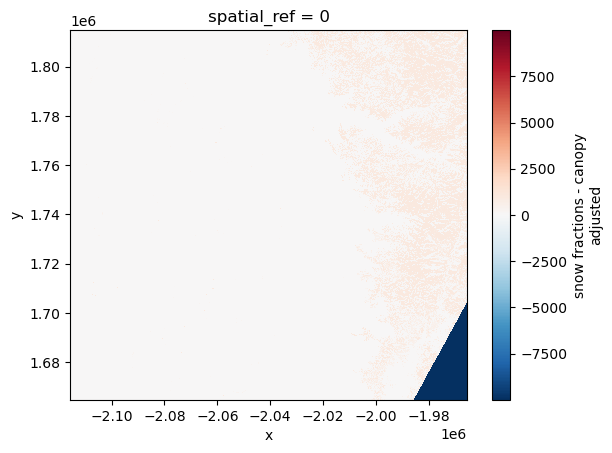

In [45]:
da.plot()

Plot scene

In [ ]:
# da.hvplot(x='x', y='y', crs='epsg:32617', rasterize=True, width=800, height=600, tiles = 'ESRI') # TODO: how to exclude fill values
# da.hvplot(x='x', y='y', crs='epsg:4326', rasterize=True, width=800, height=600)

---

## AWS CLI

List content in bucket

In [29]:
! aws s3 ls s3://usgs-landsat/collection02/level-1/standard/oli-tirs/2021/016/042/LC08_L1TP_016042_20211027_20211104_02_T1/ --request-payer requester

2021-11-05 01:37:33     116979 LC08_L1TP_016042_20211027_20211104_02_T1_ANG.txt
2021-11-05 01:37:33   77713726 LC08_L1TP_016042_20211027_20211104_02_T1_B1.TIF
2021-11-05 01:37:34   76108899 LC08_L1TP_016042_20211027_20211104_02_T1_B10.TIF
2021-11-05 01:37:36   75282069 LC08_L1TP_016042_20211027_20211104_02_T1_B11.TIF
2021-11-05 01:37:37   77374352 LC08_L1TP_016042_20211027_20211104_02_T1_B2.TIF
2021-11-05 01:37:38   77527685 LC08_L1TP_016042_20211027_20211104_02_T1_B3.TIF
2021-11-05 01:37:39   76485245 LC08_L1TP_016042_20211027_20211104_02_T1_B4.TIF
2021-11-05 01:37:40   78304185 LC08_L1TP_016042_20211027_20211104_02_T1_B5.TIF
2021-11-05 01:37:42   75847018 LC08_L1TP_016042_20211027_20211104_02_T1_B6.TIF
2021-11-05 01:37:44   73697164 LC08_L1TP_016042_20211027_20211104_02_T1_B7.TIF
2021-11-05 01:37:45  304168225 LC08_L1TP_016042_20211027_20211104_02_T1_B8.TIF
2021-11-05 01:37:48   60967770 LC08_L1TP_016042_20211027_20211104_02_T1_B9.TIF
2021-11-05 01:37:49      15036 LC08_L1TP_016042_2

Download content in bucket to local

In [ ]:
! aws s3 cp s3://usgs-landsat/collection02/level-1/standard/oli-tirs/2021/016/042/LC08_L1TP_016042_20211027_20211104_02_T1/ . --recursive --request-payer 